In this assignment, you will experiment with running a simple DNN and measuring its performance with CPU and GPU available on Google Colab. \
We provide both Pytorch & TF2.0 snippets for you to start with.

Adapted from ["PyTorch 1.2 Quickstart with Google Colab"](https://colab.research.google.com/github/omarsar/pytorch_notebooks/blob/master/pytorch_quick_start.ipynb) and ["Tensorflow 2.0 Quickstart for experts"](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb#scrollTo=DUNzJc4jTj6G)

# PyTorch version

In [ ]:
!pip3 install torch==1.9.1+cu102 torchvision==0.10.1+cu102 torchaudio===0.9.1 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
print(torch.__version__)

if torch.cuda.is_available():
    !nvidia-smi

1.9.0+cu102
Thu Sep 30 23:18:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8    29W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                            

## Import The Data `torch.utils.data.Dataloader`
The first step before training the model is to import the data. We will use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) which is like the Hello World dataset of machine learning. 

Besides importing the data, we will also do a few more things:
- We will tranform the data into tensors using the `transforms` module
- We will use `DataLoader` to build convenient data loaders or what are referred to as iterators, which makes it easy to efficiently feed data in batches to deep learning models. 
- As hinted above, we will also create batches of the data by setting the `batch` parameter inside the data loader. Notice we use batches of `32` in this tutorial but you can change it to `64` if you like. We encourage you to experiment with different batches.

In [ ]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Exploring the Data

<class 'torch.Tensor'>
Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


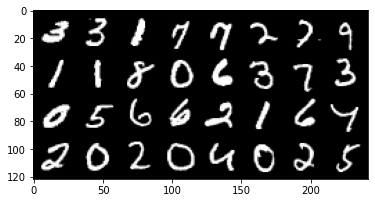

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(type(images))
## show images
imshow(torchvision.utils.make_grid(images))

## check dimensions of a batch
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

## The Model
Now using the classical deep learning framework pipeline, let's build the 1 convolutional layer model. 

Here are a few notes for those who are beginning with PyTorch:
- The model below consists of an `__init__()` portion which is where you include the layers and components of the neural network. In our model, we have a convolutional layer denoted by `nn.Conv2d(...)`. We are dealing with an image dataset that is in a grayscale so we only need one channel going in, hence `in_channels=1`. We hope to get a nice representation of this layer, so we use `out_channels=32`. Kernel size is 3, and for the rest of parameters we use the default values which you can find [here](https://pytorch.org/docs/stable/nn.html?highlight=conv2d#conv2d). 
- We use 2 back to back dense layers or what we refer to as linear transformations to the incoming data. Notice for `d1` I have a dimension which looks like it came out of nowhere. 128 represents the size we want as output and the (`26*26*32`) represents the dimension of the incoming data. If you would like to find out how to calculate those numbers refer to the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html?highlight=linear#conv2d). In short, the convolutional layer transforms the input data into a specific dimension that has to be considered in the linear layer. The same applies for the second linear transformation (`d2`) where the dimension of the output of the previous linear layer was added as `in_features=128`, and `10` is just the size of the output which also corresponds to the number of classes.
- After each one of those layers, we also apply an activation function such as `ReLU`. For prediction purposes, we then apply a `softmax` layer to the last transformation and return the output of that.  

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [ ]:
## test the model with 1 batch
model = MyModel()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


## Training the Model
Now we are ready to train the model but before that we are going to setup a loss function, an optimizer and a function to compute accuracy of the model. 

In [ ]:
learning_rate = 0.001
num_epochs = 5

# move data and model to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))        

Epoch: 0 | Loss: 1.5693 | Train Accuracy: 89.70
Epoch: 1 | Loss: 1.4910 | Train Accuracy: 97.34
Epoch: 2 | Loss: 1.4813 | Train Accuracy: 98.23
Epoch: 3 | Loss: 1.4769 | Train Accuracy: 98.64
Epoch: 4 | Loss: 1.4739 | Train Accuracy: 98.92


In [ ]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 98.06


## Benchmark performance

Please read the following post and conduct your measurement with CPU and GPU. A short write up with concise data chart and figures is good enough.

https://towardsdatascience.com/speed-up-jupyter-notebooks-20716cbe2025

### CPU write-up

click to edit

### GPU write-up

click to edit

# Tensorflow 2.0 version

In [ ]:
!pip3 install tensorflow==2.6.0 tensorflow-datasets==4.0.1

In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [ ]:
print(tf.__version__)

if tf.config.list_physical_devices('GPU'):
    !nvidia-smi

2.6.0
Tue Sep 28 05:51:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    72W / 149W |    563MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-

## Import The Data `tf.data.Dataset`
The first step before training the model is to import the data. We will use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) which is like the Hello World dataset of machine learning. 

Besides importing the data, we will also do a few more things:
- We will cast the data into float32 tensors
- We will use `tf.data.Dataset` to build convenient data loaders or what are referred to as iterators, which makes it easy to efficiently feed data in batches to deep learning models. 
- similar to PyTorch, Tensorflow 2.0 Dataset API also provides convenient transformation and batching options, in a chaining style. We encourage you to experiment with different batches.

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

11501568/11490434 [==============================] - 0s 0us/step


Use `tf.data` to batch and shuffle the dataset:

In [3]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

## Exploring the data

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


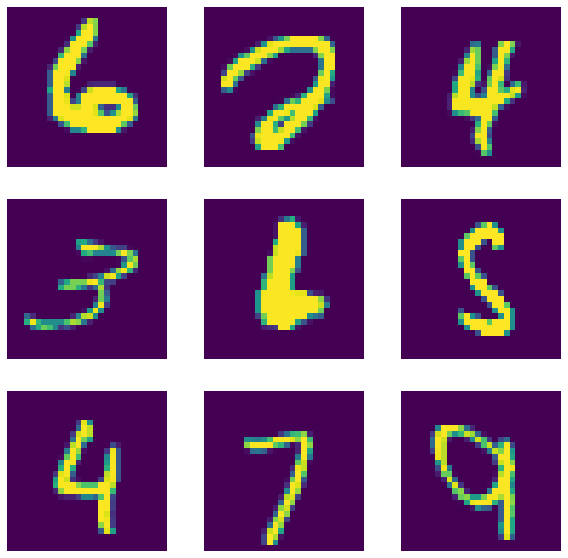

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().squeeze()) # https://stackoverflow.com/a/59601192
    plt.axis("off")

## check dimensions of a batch
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

## The Model
Now using the classical deep learning framework pipeline, let's build the 1 convolutional layer model. 

Build the `tf.keras` model using the Keras [model subclassing API](https://www.tensorflow.org/guide/keras#model_subclassing):
- The model below consists of an `__init__()` portion which is where you include the layers and components of the neural network. In our model, we have a convolutional layer denoted by `tf.keras.Conv2D(...)`. Keras infers the input dimension by itself, and we hope to get a nice representation of this layer, so we use `filters=32`. Kernel size is 3, and for the rest of parameters we use the default values which you can find [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D). 
- We use 2 back to back dense layers or what we refer to as linear transformations to the incoming data. Keras infers the dimension of input by itself. For layer parameter math, please refer to the corresponding PyTorch block above and the [TF2 Keras documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) for details. 
- Activation functions is configured within layer calls.

In [ ]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

## Training the Model
Now we are ready to train the model but before that we are going to setup a loss function, an optimizer and a function to compute accuracy of the model. 

Choose an optimizer and loss function for training: 

In [ ]:
learning_rate = 0.001
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

Use `tf.GradientTape` to train the model:

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
        %(epoch, train_loss.result(), train_accuracy.result() * 100))

Epoch: 0 | Loss: 0.1339 | Train Accuracy: 95.96
Epoch: 1 | Loss: 0.0437 | Train Accuracy: 98.63
Epoch: 2 | Loss: 0.0228 | Train Accuracy: 99.26
Epoch: 3 | Loss: 0.0141 | Train Accuracy: 99.55
Epoch: 4 | Loss: 0.0091 | Train Accuracy: 99.73


Test the model:

In [ ]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

print(f'Test Accuracy: {test_accuracy.result() * 100:.2f}')

Test Accuracy: 98.50


## Benchmark performance

Please read the following post and conduct your measurement with CPU and GPU. A short write up with concise data chart and figures is good enough.

https://towardsdatascience.com/speed-up-jupyter-notebooks-20716cbe2025

### CPU write-up

click to edit

### GPU write-up

click to edit